<a href="https://colab.research.google.com/github/FacuRoffet99/ML/blob/main/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Dónde se puede probar?
Diseñé una Web App muy simple para que se pueda probar el modelo:

*   https://mybinder.org/v2/gh/FacuRoffet99/ML/HEAD?urlpath=%2Fvoila%2Frender%2FWeb_app.ipynb

Tener en cuenta que Binder puede tardar un buen rato en inicializar el servidor (alrededor de unos 5 minutos). 

La página debe visualizarse así:

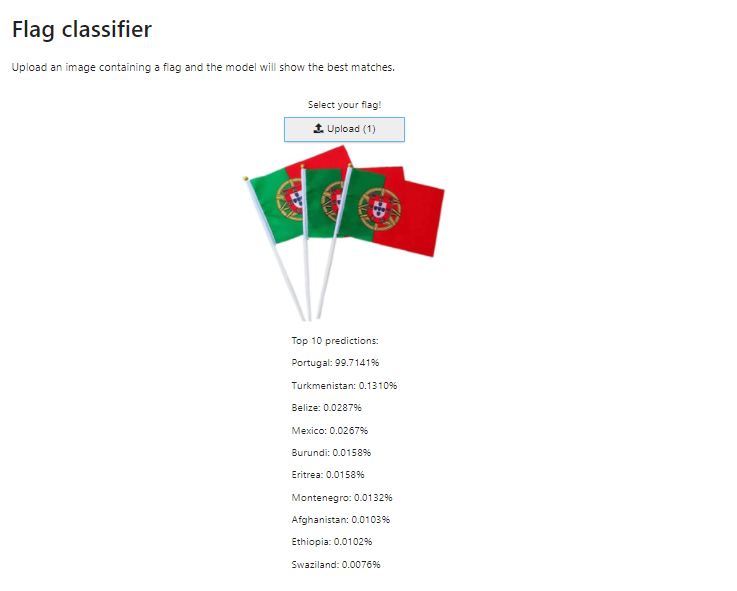




# Introducción
El objetivo de este proyecto es entrenar a una red capaz de clasificar correctamente imágenes de banderas en 193 categorías: una para cada país miembro de Naciones Unidas.

Para el entranamiento, combiné diferentes datasets para así obtener un total de 9 imágenes por país. Los mismos fueron obtenidos de los siguientes sitios:
*   https://github.com/iamvukasin/flagnet
*   https://iconscout.com/icon-pack/country-flags
*   https://dynamospanish.com/flags/
*   https://flagpedia.net/download

Sin embargo, para poder testear el modelo creé "a mano" un pequeño dataset de 175 imágenes (35 países, 5 imágenes por cada uno) a partir de resultados de Google Imágenes. Traté de que el mismo fuera lo más diferente posible del dataset de entrenamiento para comprobar qué tan generalizables son los resultados. Por ejemplo, para Noruega seleccioné las siguientes:

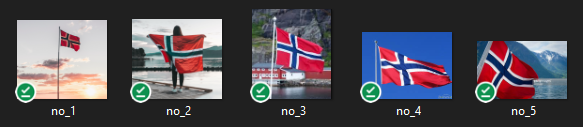

# Configuraciones

In [1]:
# Instalo FastAI
!pip3 install git+https://github.com/fastai/fastai.git

# Importo las librerias
import os
import re
import pandas as pd
from pathlib import Path
from fastai.vision.all import *

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-1ta0b7nw
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-1ta0b7nw
     |████████████████████████████████| 56 kB 4.1 MB/s 
  Created wheel for fastai: filename=fastai-2.5.4-py3-none-any.whl size=187524 sha256=27bd1ee0eae7f1377038092f99ab1cd1711c36990863564f7acb5346dac3e79b
  Stored in directory: /tmp/pip-ephem-wheel-cache-bu0b4fzc/wheels/e2/81/30/9d0af3c5b8212ceb1118de039a8973c37f047102062f346d19
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
# Defino la carpeta de trabajo
folder = Path('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Proyecto final/')
os.chdir(folder)

# Preparar los datos

Para obtener las etiquetas deseadas, primero es necesario cargar la tabla `countries_label_map` que mapea los códigos alpha-2 con los nombres de los países. Además se necesita de la función `label_func` para extraer los dos caracteres a partir de un `path` e indexar la tabla con ellos. 

In [3]:
# Cargo la tabla de mapeo
countries_label_map = pd.read_csv(folder/'countries_label_map.csv', index_col=0, encoding='latin-1')
countries_label_map.head()

,country
label,
ad,Andorra
ae,United Arab Emirates
af,Afghanistan
ag,Antigua and Barbuda
al,Albania


In [4]:
# Función para obtener las etiquetas
def label_func(path): 
  # Uso una expresión regular para extraer los dos caracteres correspondientes a la etiqueta original
  code = re.split(r'\/',str(path))[-2]
  # Y la convierto a nombre de país
  label = countries_label_map.loc[code][0]
  return label

Para evitar que el modelo "memorice" el dataset y se produzca overfitting, es necesario aplicar data augmentation. Esto hace que en cada época de entrenamiento el modelo se encuentre con versiones distorsionadas de las imágenes originales.

Nota: no aplico inversiones horizontales ni verticales porque pueden provocar una incorrecta clasificación. Esto se debe a que existen varias banderas que son las versiones inversas de otras, por ejemplo:
*   Invertir verticalmente la bandera de Polonia la convierte en la de Indonesia
*   Invertir horizontalmente la bandera de Mali la convierte en la de Guinea

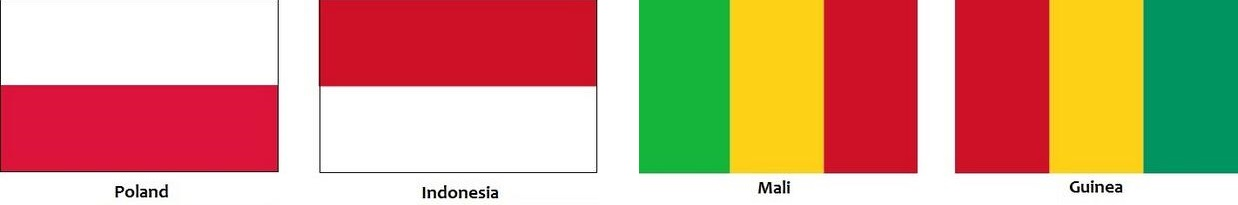



In [5]:
# Elijo los tipos de data augmentation a aplicar
data_augmentation = aug_transforms(do_flip=False,       # No invierte horizontalmente
                                   flip_vert=False,     # No invierte verticalmente 
                                   max_rotate=50.0,     # Rota al azar
                                   max_zoom=1.2,        # Crop con zoom al azar
                                   max_lighting=0.5,    # Cambia brillo y contraste al azar
                                   max_warp=0.3,        # Cambia perspectiva al azar
                                   p_affine=0.7,        # Probabilidad de rotación, crop y warpeo
                                   p_lighting=0.7)      # Probabilidad de cambios de iluminación

Utilizando la API llamada DataBlock, es sencillo preparar el dataset de forma que quede listo para pasarselo a un modelo. La variable `dls` contiene tanto al dataloader de entrenamiento como el de validación.

 

In [6]:
# Hiperparámetros
SPLIT = 0.25                                            # Porción de los datos destinados a validación
IMG_SIZE = 224                                          # Tamaño final de las imágenes
BATCH_SIZE = 64                                         # Tamaño del batch

# Elijo como ensamblar los datos
flags = DataBlock(
    blocks=(ImageBlock, CategoryBlock),                 # Creo tuplas (imagen, clase)
    get_items=get_image_files,                          # Obtengo los datos
    get_y=label_func,                                   # Etiqueto con mi propia función
    splitter=RandomSplitter(valid_pct=SPLIT, seed=18),  # Divido al azar en train y valid
    item_tfms=Resize(IMG_SIZE, method='squish'),        # Recorto y redimensiono las imágenes
    batch_tfms=data_augmentation)                       # Hago data augmentation

# Creo los dataloaders
path_train = folder/'train'
dls = flags.dataloaders(path_train, bs=BATCH_SIZE, shuffle=True)

# Exploro los datos
num_classes = dls.c
classes = dls.vocab
print('Cantidad de clases: ', num_classes)
print('Nombres de las clases: ', classes)

Cantidad de clases:  193
Nombres de las clases:  ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Federated States of Micronesia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 

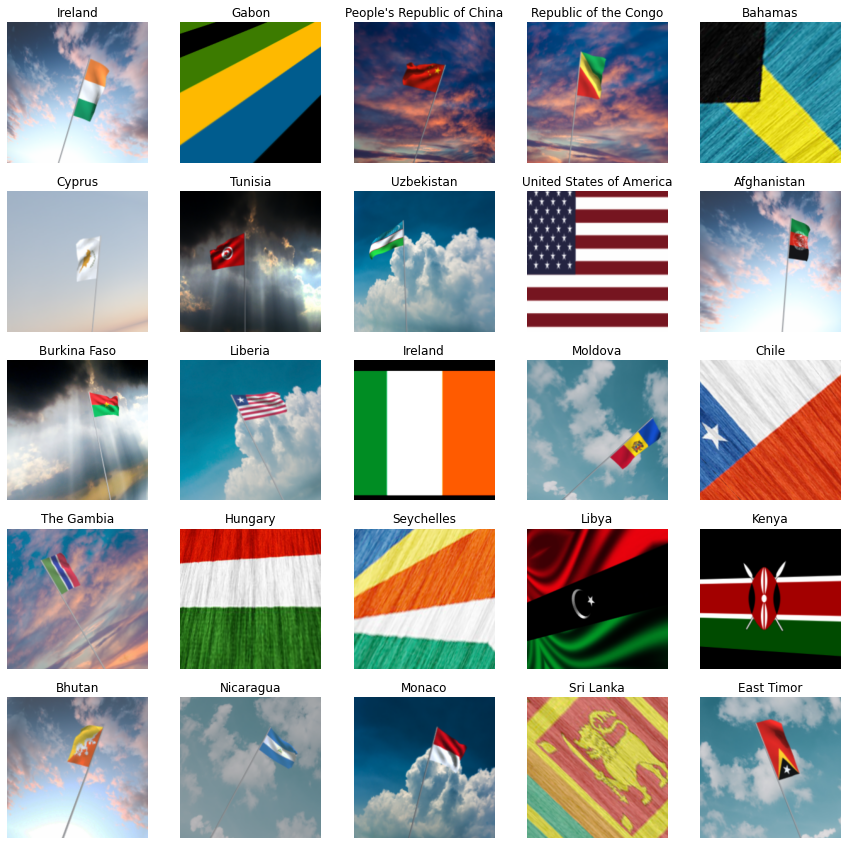

In [7]:
# Muestro un conjunto de imágenes al azar
dls.train.show_batch(max_n=25)

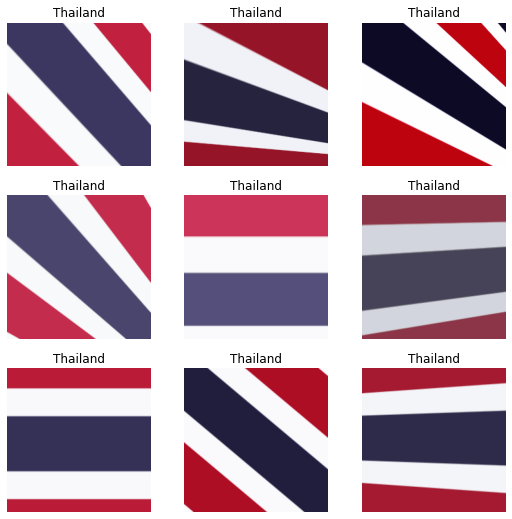

In [8]:
# Muestro diferentes versiones de una misma imagen
dls.train.show_batch(max_n=9, unique=True)

# Modelo resnet34
Para esta aplicación, no tiene sentido entrenar un modelo desde cero sino que conviene hacer fine tunning de uno pre-entrenado en Imagenette (dataset de clasificación de objetos de mil clases diferentes). De esta forma, la red es capaz de mantener los conocimientos que "aprendió" anteriormente y a su vez especializar sus últimas capas en la tarea específica que se requiere (en este caso, clasificación de banderas).

Decidí comenzar con una arquitectura resnet34, la cuál está compuesta principalmente de una red convolucional de 34 capas con skip connections.

In [13]:
# Función que calcula la accuracy del top 3 
top_3_accuracy = partial(top_k_accuracy, k=3)

# Uso dos métricas
met = [accuracy,top_3_accuracy]

# Creo y preparo el modelo para ser entrenado
learn34 = cnn_learner(dls,              # Dataloaders
                    resnet34,           # Elijo la arquitectura resnet34
                    normalize=True,     # Normalizo los datos
                    pretrained=True,    # Uso transfer learning
                    n_out=num_classes,  # Cambio la cantidad de neuronas de salida                    
                    opt_func=Adam,      # Optimizo con Adam                   
                    metrics=met,        # Elijo las métricas
                    wd=0.1).to_fp16()   # Aplico weigth decay para evitar overtting                    

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## Entrenamiento (30 épocas)

SuggestedLRs(valley=0.0030199517495930195)

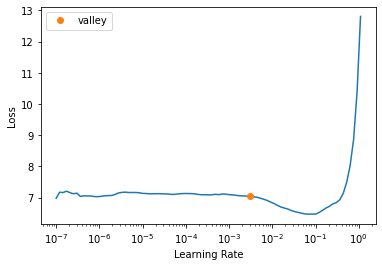

In [ ]:
# Busco cuál es el mejor learning rate
learn34.lr_find()

El learning rate, por lo general, conviene elegirlo en la zona de mayor pendiente negativa que se encuentre una década antes de la mínima loss. En este caso, sería algún número entre 3e-3 y 1e-2, por lo que elegí 7e-3.

Lo que hace el método `fine_tune` es entrenar por una época a las últimas capas (utilizando `base_lr`) mientras las demás están congeladas. Luego, descongela todas las capas y las entrena por 30 épocas con un valor entre `base_lr/200` y `base_lr/2`. Los valores más pequeños corresponden a las primeras capas, mientras que los más grandes corresponden a las últimas.

In [ ]:
# Entreno el modelo
learn34.fine_tune(30, base_lr=7e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.720207,5.464416,0.043779,0.089862,00:33


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.913847,4.671598,0.103687,0.207373,00:34
1,4.326832,3.864524,0.182028,0.345622,00:33
2,3.706656,2.944519,0.304147,0.493088,00:34
3,3.069106,2.285331,0.453917,0.658986,00:34
4,2.482482,1.793728,0.539171,0.771889,00:33
5,2.001236,1.520262,0.587558,0.797235,00:33
6,1.629397,1.336682,0.629032,0.827189,00:32
7,1.381530,1.266177,0.670507,0.841014,00:32
8,1.198777,1.316661,0.684332,0.845622,00:32
9,1.039958,1.234507,0.658986,0.861751,00:32


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42cc99ccb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Luego de 30 épocas el modelo es capaz de predecir correctamente el 90.09% de las veces sobre el dataset de validación, mientras que el 97.7% de las veces la respuesta correcta está contenida en las primeras tres predicciones. 

In [ ]:
# Guardo el modelo
learn34.save(folder/'models/resnet34_30epochs')

## Resultados del entrenamiento

In [14]:
# Cargo el modelo
learn34.load(folder/'models/resnet34_30epochs')

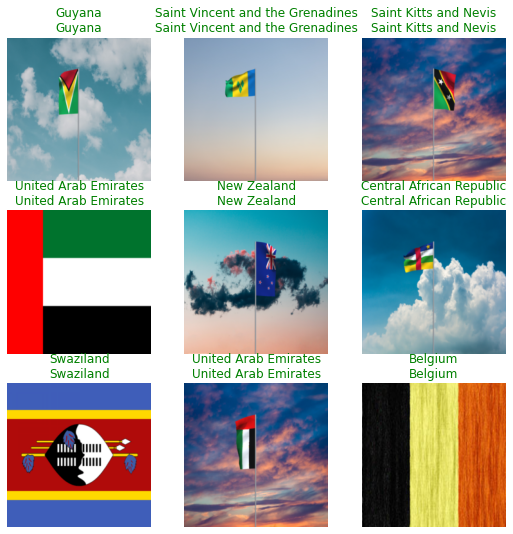

In [ ]:
# Muestro resultados al azar
learn34.show_results()

In [ ]:
# Creo un interpretador de resultados
interp34 = ClassificationInterpretation.from_learner(learn34)

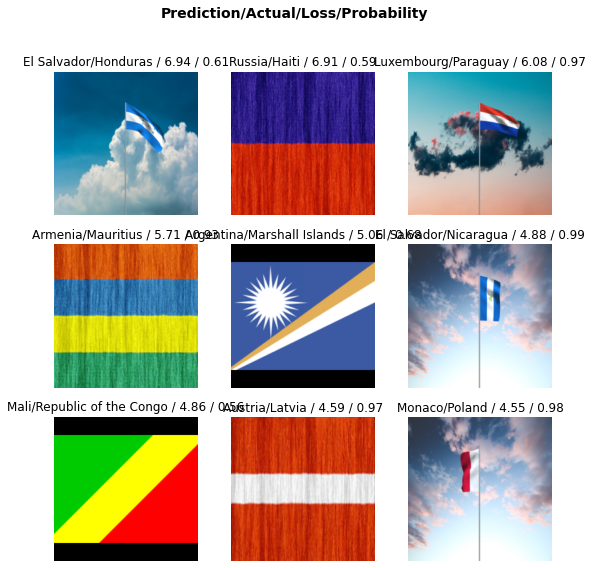

In [ ]:
# Plotteo las imágenes con mayor loss
interp34.plot_top_losses(range(0,9))

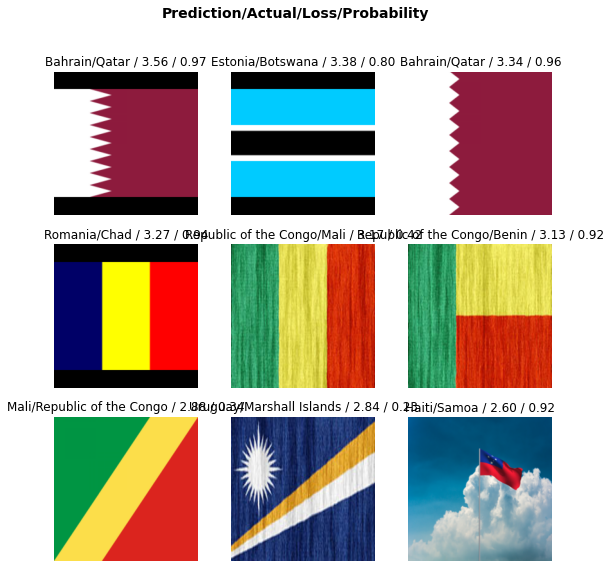

In [ ]:
# Plotteo las imágenes con mayor loss
interp34.plot_top_losses(range(9,18))

In [ ]:
# Miro cuáles son los errores que más se repiten
interp34.most_confused()

[('Chad', 'Romania', 4),
 ('Qatar', 'Bahrain', 2),
 ('Republic of the Congo', 'Mali', 2),
 ('Armenia', 'Mauritius', 1),
 ('Austria', 'Indonesia', 1),
 ('Benin', 'Cameroon', 1),
 ('Benin', 'Republic of the Congo', 1),
 ('Botswana', 'Estonia', 1),
 ('Burkina Faso', 'Senegal', 1),
 ('Haiti', 'Russia', 1),
 ('Honduras', 'El Salvador', 1),
 ('Hungary', 'Luxembourg', 1),
 ('Indonesia', 'Monaco', 1),
 ('Ireland', 'Ivory Coast', 1),
 ('Kingdom of the Netherlands', 'Latvia', 1),
 ('Latvia', 'Austria', 1),
 ('Lesotho', 'Finland', 1),
 ('Liechtenstein', 'Haiti', 1),
 ('Mali', 'Guinea', 1),
 ('Mali', 'Republic of the Congo', 1),
 ('Marshall Islands', 'Argentina', 1),
 ('Marshall Islands', 'Russia', 1),
 ('Marshall Islands', 'Uruguay', 1),
 ('Mauritius', 'Armenia', 1),
 ('Monaco', 'Indonesia', 1),
 ('Monaco', 'Poland', 1),
 ('New Zealand', 'Australia', 1),
 ('Nicaragua', 'El Salvador', 1),
 ('Paraguay', 'Luxembourg', 1),
 ('Poland', 'Monaco', 1),
 ('Romania', 'Chad', 1),
 ('Samoa', 'Haiti', 1),
 ('

Como se puede observar en las tres celdas anteriores, el modelo comete ciertos errores. Algunos son comprensibles, y otros no tanto:


*   Las banderas de Chad y Rumania son prácticamente (por no decir exactamente) iguales, por lo que era de esperarse que la red se las confunda.
*   Mismo caso que los tríos Polonia/Mónaco/Indonesia y El Salvador/Nicaragua/Honduras.
*   Las de Qatar y Bahrein son bastante similares (solo cambia la tonalidad del rojo).
*   Hay confusión entre las banderas que tienen verde/amarillo/rojo como es el caso de Mali, Guinea y República del Congo, lo cuál es entendible. Quizás un poco más extraño es el caso de Benin ya que su disposición de colores es bastante diferente.
*   El error más sobresaliente es el caso de las Islas Marshall, cuya bandera es bastante diferente a todas las demás. Sin embargo, el modelo la confunde con Argentina, Rusia y Uruguay. 
*   También hay otros varios pares que generan problemas, pero su frecuencia de aparición es baja.







# Modelo resnet50
Para intentar conseguir mejores resultados, probé utilizar la arquitectura resnet50 que posee más capas que la anterior.

In [19]:
# Función que calcula la accuracy del top 3 
top_3_accuracy = partial(top_k_accuracy, k=3)

# Uso dos métricas
met = [accuracy,top_3_accuracy]

# Creo y preparo el modelo para ser entrenado
learn50 = cnn_learner(dls,              # Dataloaders
                    resnet50,           # Elijo la arquitectura resnet34
                    normalize=True,     # Normalizo los datos
                    pretrained=True,    # Uso transfer learning
                    n_out=num_classes,  # Cambio la cantidad ded neuronas de salida                    
                    opt_func=Adam,      # Optimizo con Adam                   
                    metrics=met,        # Elijo las métricas
                    wd=0.1).to_fp16()   # Aplico weigth decay para evitar overtting  

## Entrenamiento (40 épocas)

SuggestedLRs(valley=0.0012022644514217973)

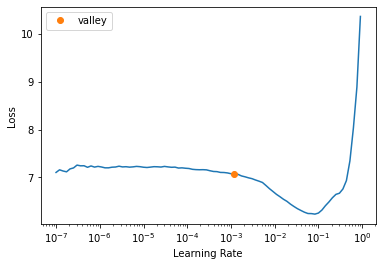

In [ ]:
# Busco cuál es el mejor learning rate
learn50.lr_find()

Siguiendo la misma lógica del caso anterior, elegí un learning rate de 5e-3.

In [12]:
learn50.fine_tune(40, base_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.810885,5.681409,0.059908,0.117512,00:29


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.496152,4.132243,0.179724,0.306452,00:29
1,3.763506,3.158028,0.306452,0.460829,00:29
2,3.068691,2.398484,0.449309,0.603687,00:29
3,2.450718,1.776730,0.548387,0.728111,00:29
4,1.931525,1.397335,0.654378,0.808756,00:29
5,1.532869,1.127108,0.682028,0.864055,00:29
6,1.236099,1.095134,0.725806,0.864055,00:29
7,1.028339,1.109089,0.732719,0.891705,00:29
8,0.865406,1.066171,0.732719,0.896313,00:29
9,0.753707,1.024241,0.732719,0.898618,00:30


Luego de 40 épocas el modelo es capaz de predecir correctamente el 91.94% de las veces sobre el dataset de validación, mientras que el 98.62% de las veces la respuesta correcta está contenida en las primeras tres predicciones. 

In [ ]:
# Guardo el modelo
learn50.save(folder/'models/resnet50_40epochs')

Path('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Proyecto final/models/resnet50_50epochs_flagpedia.pth')

## Resultados del entrenamiento

In [20]:
# Cargo el modelo
learn50.load(folder/'models/resnet50_40epochs')

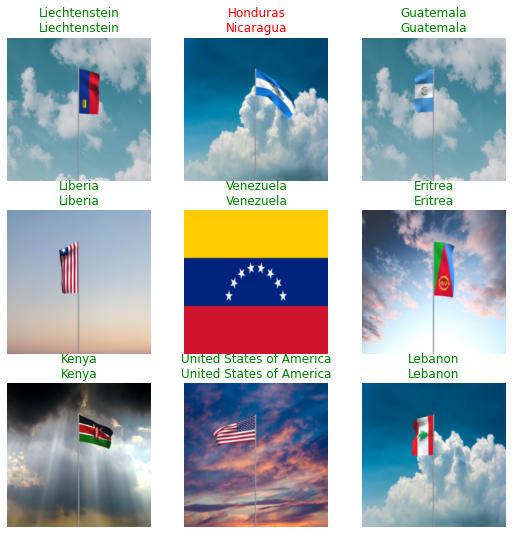

In [ ]:
# Muestro resultados al azar
learn50.show_results()

In [ ]:
# Creo un interpretador de resultados
interp50 = ClassificationInterpretation.from_learner(learn50)

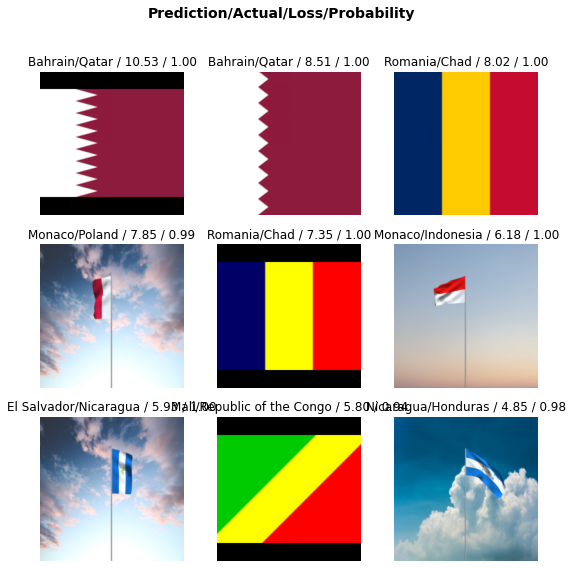

In [ ]:
# Plotteo las imágenes con mayor loss
interp50.plot_top_losses(range(0,9))

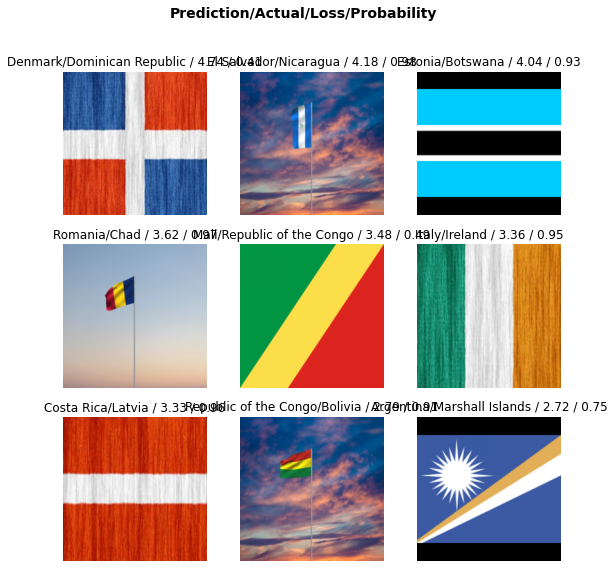

In [ ]:
# Plotteo las imágenes con mayor loss
interp50.plot_top_losses(range(9,18))

In [ ]:
# Miro cuáles son los errores que más se repiten
interp50.most_confused()

[('Chad', 'Romania', 4),
 ('Republic of the Congo', 'Mali', 3),
 ('Ireland', 'Ivory Coast', 2),
 ('Nicaragua', 'El Salvador', 2),
 ('Qatar', 'Bahrain', 2),
 ('Belgium', 'Romania', 1),
 ('Bolivia', 'Republic of the Congo', 1),
 ('Botswana', 'Estonia', 1),
 ('Dominican Republic', 'Denmark', 1),
 ('Greece', 'Israel', 1),
 ('Haiti', 'Russia', 1),
 ('Honduras', 'Nicaragua', 1),
 ('Indonesia', 'Monaco', 1),
 ('Ireland', 'Italy', 1),
 ('Kingdom of the Netherlands', 'Luxembourg', 1),
 ('Latvia', 'Costa Rica', 1),
 ('Lesotho', 'Nicaragua', 1),
 ('Mali', 'Guinea', 1),
 ('Marshall Islands', 'Argentina', 1),
 ('Moldova', 'Andorra', 1),
 ('Paraguay', 'Kingdom of the Netherlands', 1),
 ('Poland', 'Monaco', 1),
 ('Romania', 'Chad', 1),
 ('Turkmenistan', 'Portugal', 1)]

Nuevamente, los pares de confusión que más se repiten son los que tienen banderas muy similares, tales como Chad/Rumania, Nicaragua/El Salvador y Costa de Marfil/Irlanda. Sin embargo, ahora hay unos cuantos menos casos aislados de error y el raro caso de las Islas Marshall parece solucionado (o al menos, mejorado).



# Testeo y comparación de modelos

In [15]:
# Función para obtener las métricas del test set
def validate(learner, files, classes):
  # Inicializo las cuentas
  acc = 0
  acc_top_3 = 0

  # Recorro cada imagen
  for f in files:
    # Obtengo las predicciones y las ordeno por probabilidad
    pred_class, pred_idxs, outputs = learner.predict(f)
    top_3_conf, index = outputs.topk(3)
    # Si la clase más probable es la correcta, sube la accuracy
    if pred_class == label_func(f):
      acc += 1  
    # Si una de las 3 clases más probable es la correcta, sube la accuracy de top 3
    for i in index:
      if classes[i.item()] == label_func(f):
        acc_top_3 += 1
        
  return (acc/len(files), acc_top_3/len(files))

In [ ]:
# Obtengo las imágenes de testeo
files_test = get_image_files(folder/'test')

# Calculo las métricas de entrenamiento
train_34 = learn34.validate()
train_50 = learn50.validate()
# Calculo las métricas de testeo
test_34 = validate(learn34, files_test, classes)
test_50 = validate(learn50, files_test, classes)

In [18]:
# Muestro las métricas de entrenamiento
print('Resultados de entrenamiento')
print('Modelo resnet34: Acc: ', train_34[1], 'Top3: ', train_34[2])
print('Modelo resnet50: Acc: ', train_50[1], 'Top3: ', train_50[2])

Resultados de entrenamiento
Modelo resnet34: Acc:  0.900921642780304 Top3:  0.9769585132598877
Modelo resnet50: Acc:  0.9193548560142517 Top3:  0.9861751198768616


In [22]:
# Muestro las métricas de testeo
print('Resultados de testeo')
print('Modelo resnet34: Acc: ', test_34[0], 'Top3: ', test_34[1])
print('Modelo resnet50: Acc: ', test_50[0], 'Top3: ', test_50[1])

Resultados de testeo
Modelo resnet34: Acc:  0.5714285714285714 Top3:  0.7028571428571428
Modelo resnet50: Acc:  0.6857142857142857 Top3:  0.8114285714285714


De los resultados anteriores, se observa que la red con arquitectura resnet50 es superior en todas las métricas a la resnet34. Esta diferencia es aun más notoria (y significativa) en el dataset de testeo, por lo que fue el modelo elegido para utilizar en la Web App.

Sin embargo, ambos modelos disminuyen considerablemente su rendimiento cuando se pasa de entrenamiento a validación. Esto lleva a pensar que el dataset utilizado para el entrenamiento no es lo suficientemente representativo (y quizás tampoco lo suficientemente grande) de forma que los modelos sean robustos como para adaptarse a los casos de uso reales. Intenté buscar otros datasets en internet para ver si podía solucionar este problema, pero como no encontré ninguno mejor (y como armar uno propio es un proceso extremadamente tedioso) me tuve que conformar con estos resultados.

# Conclusiones/comentarios

Este proyecto me llevó dos semanas de bastante trabajo, pero realmente lo disfruté mucho. No dejo de sorprenderme de lo fácil, rápido y útil que es usar la librería de FastAI, sobre todo al haber visto (incluso más de una vez) el curso Practical Deep Learning for Coders:

*   https://course.fast.ai/

Además, puedo asegurar que la librería está super optimizada. Mi idea original era trabajar directamente sobre Pytorch, pero el proceso era mucho más complejo y los resultados ni siquiera se aproximaban a los que presento en esta notebook.

En cuanto a los resultados finales, estoy un poco decepcionado de que (como dije en la sección anterior) el dataset de entrenamiento no haya sido suficiente para que el modelo pueda generalizar correctamente a otros tipos de fotos. Algunos errores recurrentes que pude observar jugando con la Web App son:

*   Al modelo le cuesta mucho distinguir entre las banderas que tienen celeste. Es común que se confunda Botswana, Estonia, Argentina, Nicaragua, Honduras y El Salvador.
*   Si la imagen de entrada es una foto que tiene algún objeto en el fondo (por ejemplo, un edificio), la perfomance suele disminuir.
*   Los resultados son buenos cuando la bandera de la imagen está en primer plano.
*   Que la imagen sea un dibujo en vez de una foto no representa un problema.

De todas formas, considero que los resultados son muy buenos, sobre todo si se tiene en cuenta que la cantidad de clases de clasificación es grande y que este es mi primer proyecto de este estilo. 





